# Defective Rail Classification from Track Images based on EfficientNet

## Import and Install Library 

In [22]:
!pip install -q efficientnet
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import efficientnet.tfkeras as efn
from tensorflow.keras import models, layers, optimizers, regularizers, callbacks
from sklearn.metrics import classification_report, confusion_matrix

## Import Dataset 

In [26]:
train_dir = 'D:/TCDEIE/transport/project/Train'
val_dir   = 'D:/TCDEIE/transport/project/Validation'
test_dir  = 'D:/TCDEIE/transport/project/Test'

# Directory with training defective/nondefective pictures
train_defective_dir = os.path.join('D:/TCDEIE/transport/project/Train/Defective')
train_nondefective_dir = os.path.join('D:/TCDEIE/transport/project/Train/Non defective')

# Directory with validation defective/nondefective pictures
validation_defective_dir = os.path.join('D:/TCDEIE/transport/project/Validation/Defective')
validation_nondefective_dir = os.path.join('D:/TCDEIE/transport/project/Validation/Non defective')

In [27]:
train_defective_fnames = os.listdir(train_dir+'/Defective' )
train_nondefective_fnames = os.listdir(train_dir+'/Non defective')

print(train_defective_fnames[:20])
print(train_nondefective_fnames[:20])

['131004959_171473721383413_8222187747086021011_n.jpg', '131051004_382613492830631_1306891331783850055_n.jpg', '131065180_999185033824671_7735147288489715620_n.jpg', '131084537_190751489449739_279862595635733772_n.jpg', '131092897_149705809860659_8798464983059531038_n.jpg', '131098429_134147575143001_1246437012995704959_n.jpg', '131129946_140815574232570_8925999503657494497_n.jpg', '131275810_2686956714949012_5021348409242545922_n.jpg', '131348023_405054987354853_8834671660058234194_n.jpg', '131437543_500273490949549_5045378072687137331_n.jpg', '2007.05.16_-_002_Broken_rail_weld_-_Flickr_-_faxepl (1).jpg', '2007.05.16_-_002_Broken_rail_weld_-_Flickr_-_faxepl.jpg', '6411009.jpg', '89e8b1a9ca8c41919021f8f4faaf37f0.jpg', 'azer2003120026fbtr.jpg', 'b17bf671d87cb6c9d6cfcd2aafc8e13a.jpg', 'Broken_railroad_tracks_1.jpg', 'cracked-rail.webp', 'damagetotrackfromcollisionlfb.jpg', 'dbb9223f7e652986a00c0dd8d8f1ccf8 (1).jpg']
['IMG_20201114_100021.jpg', 'IMG_20201114_100032.jpg', 'IMG_20201114_100

In [28]:
print('total training defective images :', len(os.listdir(train_defective_dir)))
print('total training non-defective images :', len(os.listdir(train_nondefective_dir)))

print('total validation defective images :', len(os.listdir( validation_defective_dir ) ))
print('total validation non-defective images :', len(os.listdir( validation_nondefective_dir) ))

total training defective images : 150
total training non-defective images : 150
total validation defective images : 31
total validation non-defective images : 31


## Plot some dataset images

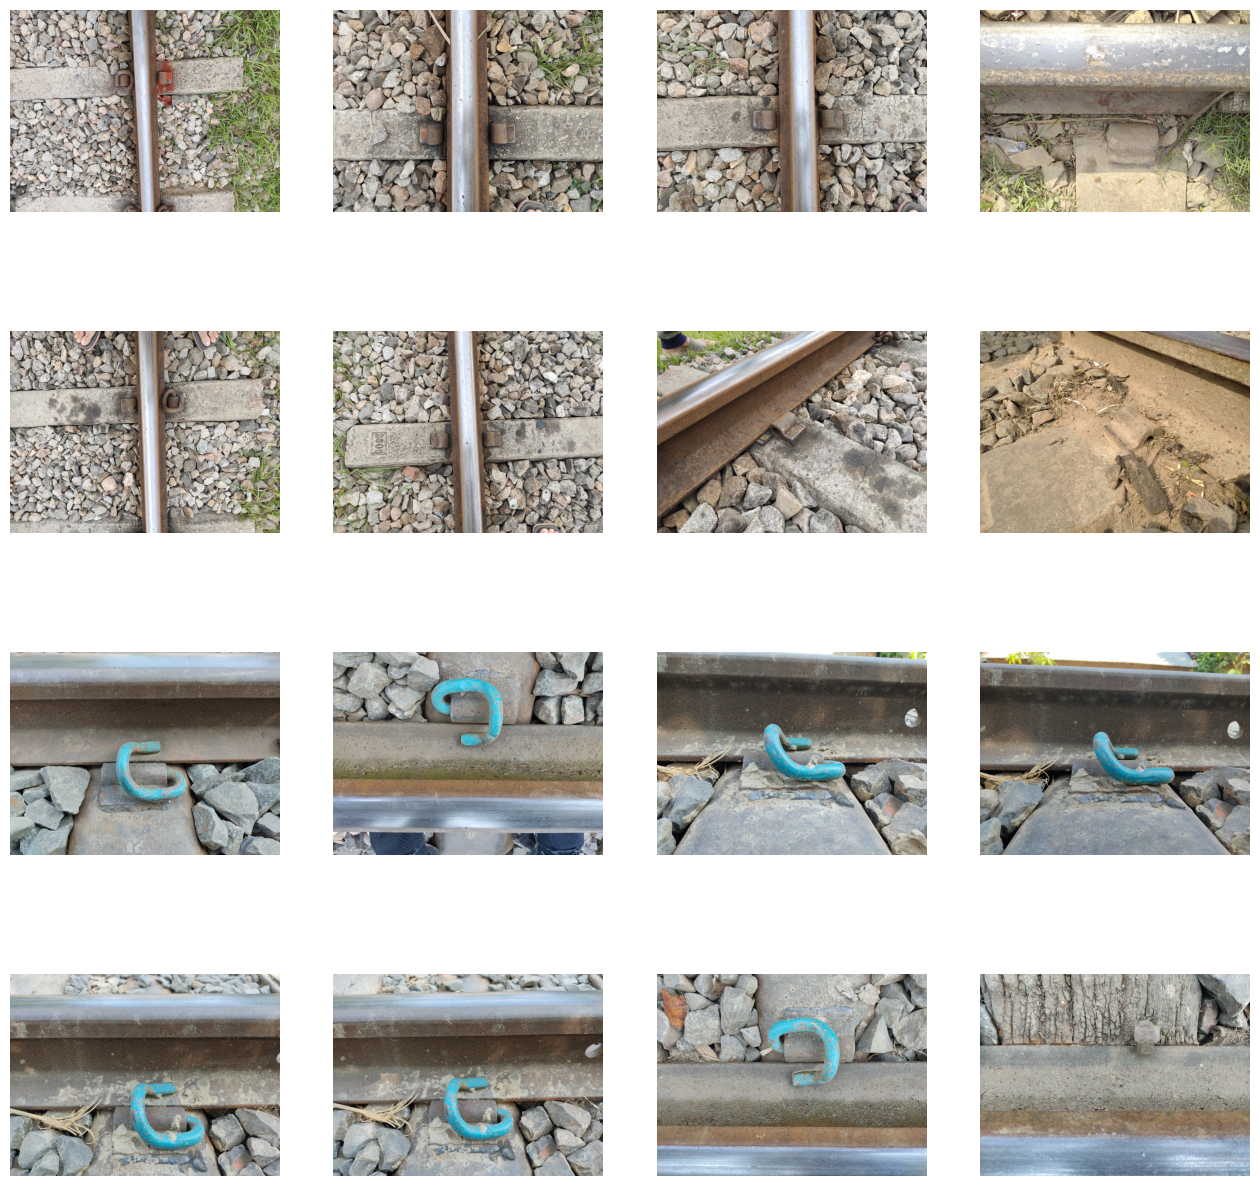

In [29]:
# Parameters for our graph; we'll output images in a 10x10 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_defective_pix = [os.path.join(train_dir+'/Defective', fname) 
                for fname in train_defective_fnames[pic_index-8:pic_index]]
next_nondefective_pix = [os.path.join(train_dir+'/Non defective', fname) 
                for fname in train_nondefective_fnames[pic_index-8:pic_index]]


for i, img_path in enumerate(next_defective_pix+next_nondefective_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

## Data Augmentation

In [30]:
target_size=(300,300)
batch_size = 16

In [31]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    color_mode='rgb',    
    shuffle=True,
    seed=42,
    class_mode='categorical')

Found 299 images belonging to 2 classes.


In [32]:
val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=target_size,
    batch_size=batch_size,
    color_mode='rgb',
    shuffle=False,    
    class_mode='categorical')

Found 62 images belonging to 2 classes.


In [33]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=batch_size,
    color_mode='rgb',
    shuffle=False,     
    class_mode=None)

Found 22 images belonging to 2 classes.


## Build the EfficienetNet Model 

In [34]:
num_classes = 2
input_shape = (300,300,3)

In [13]:
base_model = efn.EfficientNetB7(input_shape=input_shape, weights='imagenet', include_top=False)
base_model.trainable = False # freeze the base model (for transfer learning)

x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128)(x)
out = layers.Dense(num_classes, activation="softmax")(x)

model = models.Model(inputs=base_model.input, outputs=out)

model.summary()

258434480/258434480 [==============================] - 270s 1us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv (Conv2D)             (None, 150, 150, 64  1728        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 stem_bn (BatchNormalization)   (None, 150, 150, 64  256         ['stem_conv[0][0]']              
                         

In [14]:
# compile model
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

## Train the model 

In [15]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VAL  =val_generator.n//val_generator.batch_size
STEP_SIZE_TEST =test_generator.n//test_generator.batch_size
num_epochs = 30

In [16]:
# Train Model
history = model.fit(train_generator,steps_per_epoch=STEP_SIZE_TRAIN,epochs=num_epochs, validation_data=val_generator, validation_steps=STEP_SIZE_VAL) #, callbacks=[checkpoint])

Epoch 1/30
18/18 [==============================] - 192s 9s/step - loss: 0.9367 - accuracy: 0.5512 - val_loss: 0.5137 - val_accuracy: 0.7083
Epoch 2/30
18/18 [==============================] - 146s 8s/step - loss: 0.5568 - accuracy: 0.7208 - val_loss: 0.5952 - val_accuracy: 0.7708
Epoch 3/30
18/18 [==============================] - 145s 8s/step - loss: 0.5512 - accuracy: 0.7527 - val_loss: 0.6428 - val_accuracy: 0.7292
Epoch 4/30
18/18 [==============================] - 148s 8s/step - loss: 0.5743 - accuracy: 0.7279 - val_loss: 0.7889 - val_accuracy: 0.7083
Epoch 5/30
18/18 [==============================] - 143s 8s/step - loss: 0.5611 - accuracy: 0.7633 - val_loss: 0.4563 - val_accuracy: 0.7083
Epoch 6/30
18/18 [==============================] - 148s 8s/step - loss: 0.5550 - accuracy: 0.7633 - val_loss: 0.4273 - val_accuracy: 0.8333
Epoch 7/30
18/18 [==============================] - 148s 8s/step - loss: 0.4999 - accuracy: 0.7668 - val_loss: 0.5760 - val_accuracy: 0.7292
Epoch 8/30
18

## Save the model  

In [17]:
## Save Model
models.save_model(model, 'railway_track_fault_detection.h5')

## Evaluate the model with some metrics and its confusion matrix 

In [18]:
score = model.evaluate(test_generator, steps=STEP_SIZE_TEST) # with test dataset
print(score)

1/1 [==============================] - 9s 9s/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
[0.0, 0.0]


In [19]:
predY=model.predict(test_generator) # with validation dataset
y_pred = np.argmax(predY,axis=1)
y_actual = test_generator.classes
cm = confusion_matrix(y_actual, y_pred)
print(cm)

2/2 [==============================] - 18s 2s/step
[[ 8  3]
 [ 1 10]]


In [20]:
# report confusion matrix
labels = ['Defective', 'Non Defective']
print(classification_report(y_actual, y_pred, target_names=labels))

               precision    recall  f1-score   support

    Defective       0.89      0.73      0.80        11
Non Defective       0.77      0.91      0.83        11

     accuracy                           0.82        22
    macro avg       0.83      0.82      0.82        22
 weighted avg       0.83      0.82      0.82        22



## Plot training and validation loss per epoch 
## Plot training and validation accuracy per epoch

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


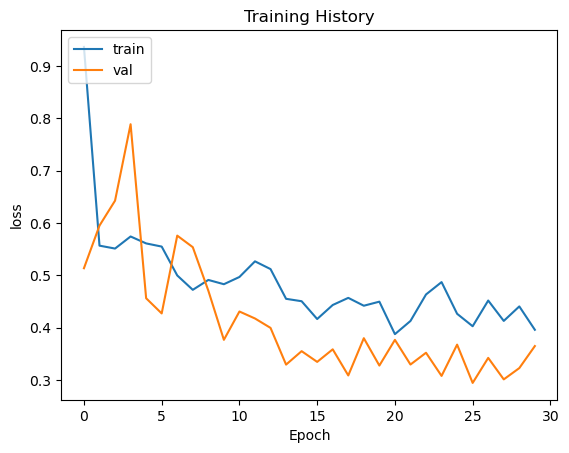

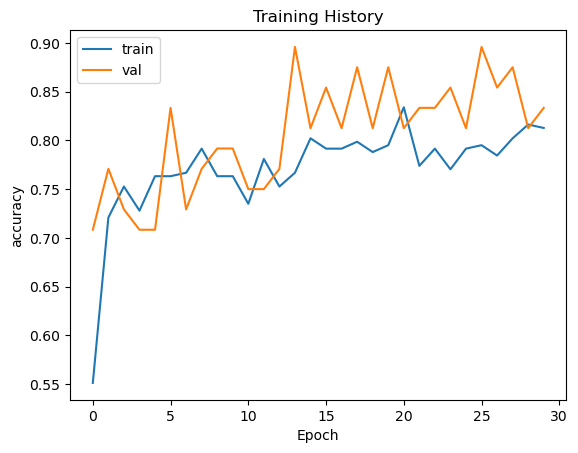

In [21]:
# Show Train History
keys=history.history.keys()
print(keys)

def show_train_history(hisData,train,val): 
    plt.plot(hisData.history[train])
    plt.plot(hisData.history[val])
    plt.title('Training History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

show_train_history(history, 'loss', 'val_loss')
show_train_history(history, 'accuracy', 'val_accuracy')

## Test the model performance by Visualizing Intermediate Representations  

1/1 [==============================] - 1s 559ms/step
[[2.1727876e-06 9.9999785e-01]]
Healthy Track


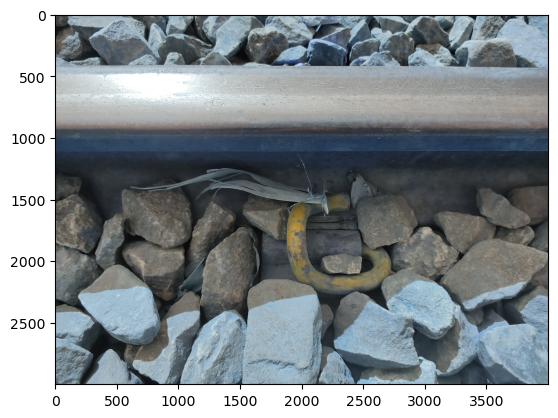

In [39]:
# Healthy track image test
img = cv2.imread('D:/TCDEIE/transport/project/Test/Non defective/IMG_20201114_102431.jpg')
plt.imshow(img)
img = cv2.resize(img,(300,300))
img = np.reshape(img,[1,300,300,3])

classes = model.predict(img)

print(classes)
if classes.all()>0.5:
    print("Healthy Track")
else:
    print("Defective Track")

In [41]:
print("Project End")

Project End
